In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# check cuda availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
# loading in test data and set model-related param (window size) 

path_to_data_to_test_against = "./movementSensorData.csv"
df=pd.read_csv(path_to_data_to_test_against)

In [8]:
# functions for preprocessing

def scale_columns(df, columns):
    """
    Scales specified columns in the dataframe using StandardScaler.

    :param df: Pandas DataFrame.
    :param columns: List of column names to scale.
    :return: DataFrame with scaled columns.
    """
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return scaler, df

def create_windows(df, window_size=3, skip=1):
    """
    Creates windows of data for each segment.

    :param df: DataFrame with the columns 'lw_x', 'lw_y', 'lw_z', 'activity', 'segment'.
    :param window_size: Size of each window.
    :param skip: Number of rows to skip for the next window.
    :return: Tuple of numpy arrays (X, y).
    """
    X, y = [], []
    unique_segments = np.unique(df['segment'])

    # Convert required columns to NumPy arrays once, outside the loop
    lw_cols = df[['lw_x', 'lw_y', 'lw_z']].to_numpy()
    activities = df['activity'].to_numpy()

    for segment in unique_segments:
        segment_indices = np.flatnonzero(df['segment'].to_numpy() == segment)
        max_index = segment_indices[-1]

        # Use array slicing instead of DataFrame indexing in the loop
        for start in segment_indices:
            end = start + window_size
            if end <= max_index + 1:
                X.append(lw_cols[start:end])
                y.append(activities[end - 1])
                start += skip
    
    return np.array(X), np.array(y)
    
                
                
def append_segments(df):
    # checks for consecutive timesteps
    df['time_diff'] = df['time_ms'].diff()

    # Initialize the segment number
    segment = 0
    segments = []

    # Iterate over the time_diff column to assign segment numbers
    for diff in df['time_diff']:
        if diff > 1:
            segment += 1
        segments.append(segment)

    # Add the segment numbers to the DataFrame
    df['segment'] = segments
    print('TOTAL SEGMENTS = ', segment)
    return df

In [9]:
# preprocessing of data

# changing label name and creating segment labels so all windows only span consecutive timesteps
df = df.rename(columns={'Unnamed: 0': 'time_ms'})
df = append_segments(df)
df_copy = df.copy()

# change so labels for loss or consecutive
df_copy['activity'].replace({77: 0}, inplace=True)

# Normalize specific columns
columns_to_normalize = ['lw_x', 'lw_y', 'lw_z']
scaler, df_copy = scale_columns(df_copy, columns_to_normalize)

# create windows of size compatiable with model
window_size = 300
X_test, y_test = create_windows(df_copy, window_size)

# convert to tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create a pytorch dataset and data loader
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


TOTAL SEGMENTS =  4


In [10]:
# define model to fill with trained params (required to load the model)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.fc(out)
        return out
    
    
# load in pretrained model
path_to_trained_model = f'submission_model_new_split_window_size_300.pth'
trained_model = torch.load(path_to_trained_model).to(device)

In [11]:
# for gathering data to evaluating model performance

trained_model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Make predictions
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())


Accuracy: 99.93%


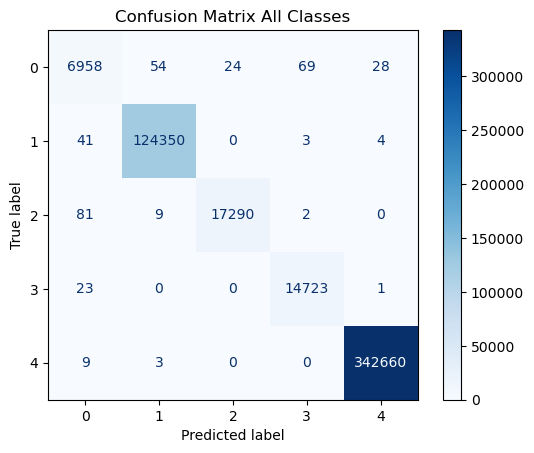

Classification Report All Classes:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7133
           1       1.00      1.00      1.00    124398
           2       1.00      0.99      1.00     17382
           3       0.99      1.00      1.00     14747
           4       1.00      1.00      1.00    342672

    accuracy                           1.00    506332
   macro avg       0.99      0.99      0.99    506332
weighted avg       1.00      1.00      1.00    506332



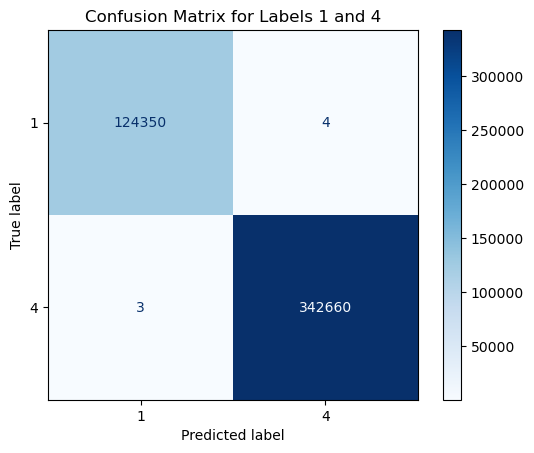

Classification Report for labels 1 and 4:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    124398
           4       1.00      1.00      1.00    342672

   micro avg       1.00      1.00      1.00    467070
   macro avg       1.00      1.00      1.00    467070
weighted avg       1.00      1.00      1.00    467070

Accuracy for labels 1 and 4: 99.99%


In [12]:
# visualising performance

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# results for all classes
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix All Classes")
plt.show()

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report All Classes:")
print(class_report)

# results for labels 1 and 4 only (walking and driving)
mask = np.isin(true_labels, [1, 4])
true_labels_1_4 = true_labels[mask]
predicted_labels_1_4 = predicted_labels[mask]

conf_matrix_1_4 = confusion_matrix(true_labels_1_4, predicted_labels_1_4, labels=[1, 4])
disp_1_4 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1_4, display_labels=[1, 4])
disp_1_4.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Labels 1 and 4")
plt.show()

class_report_1_4 = classification_report(true_labels_1_4, predicted_labels_1_4, labels=[1, 4])
print("Classification Report for labels 1 and 4:")
print(class_report_1_4)

accuracy_1_4 = accuracy_score(true_labels_1_4, predicted_labels_1_4)
print(f'Accuracy for labels 1 and 4: {accuracy_1_4 * 100:.2f}%')